# Rat weight gain data in lmer, lmm, Stan and Mamba

An example that is frequently used to illustrate MCMC methods is the weight gain of baby rats.  This is a completely balanced data set of weekly observations from 8 days until 36 days on each of 30 rats.  Because it is completely balanced it is usually presented as a matrix.  We will do the initial data manipulation in [R](http://R-project.org) through the [RCall](https://github.com/JuliaStats/RCall.jl) package for [Julia](https://julialang.org).  We could use `read.table` from base R but instead we'll do what the cool kids are doing and use the `readr`, `tidyr` and `dplyr` packages.

## Reading and tidying the data

In [1]:
using RCall
"""
library(readr)
library(tidyr)
library(lattice)
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(lme4))

rats <- read_delim("rats.txt", " ") %>%
    dplyr::mutate(id = seq_len(length(day8))) %>%
    tidyr::gather(day, weight, day8:day36) %>%
    dplyr::mutate(day = as.integer(substring(day,4)))
glimpse(rats)
""" |> reval

RCall.RObject{RCall.NilSxp}
Observations: 150
Variables: 3
$ id     (int) 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...
$ day    (int) 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...
$ weight (int) 151, 145, 147, 155, 135, 159, 141, 159, 177, 134, 160, 143, ...
NULL


The text within the triple double quotes (`"""`) is read as a single string which is piped to the `reval` function, which sends it to be parsed and evaluated as R code.  The R code loads and attaches five packages then uses the `tidyr::read_delim` function to read the blank-delimited file, _rats.txt_, adds a column of the rat `id` using `dplyr::mutate`, switch from the wide to the long format using `tidyr::gather` then convert the character strings of the form "day8" up to "day36" to integers by dropping the first three characters.

At this point we do something radical and plot the data.  I have never seen a data plot in any of the MCMC exampes that use these data.

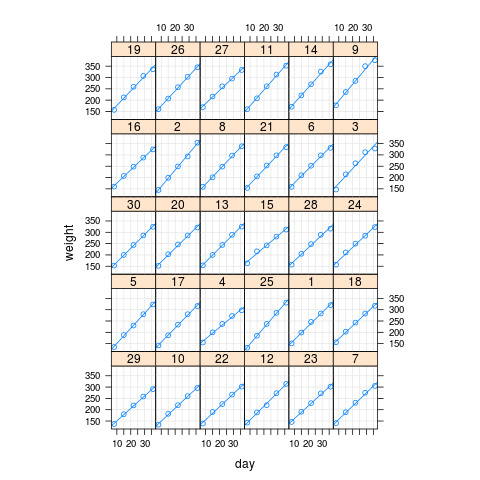

RCall.RObject{RCall.VecSxp}


In [2]:
"""
print(xyplot(weight ~ day | reorder(id, weight), rats, type = c('p','g','r'), aspect = 'xy'))
""" |> reval

There is an overall linear trend in the weight with respect to time but there is also noticeable downward curvature for many of the rats.  Nevertheless we will start with a model with linear model with vector-valued random effects for slope and intercept by rat.

## Fitting the vector-valued random effects in lme4

The simplest way to write the model is `weight ~ 1 + day + (1 + day|id)` which allows for correlated random effects for slope and intercept for each rat.

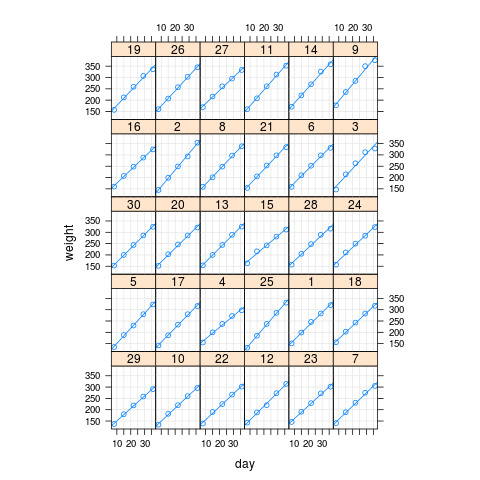

RCall.RObject{RCall.VecSxp}
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: weight ~ 1 + day + (1 + day | id)
   Data: rats

     AIC      BIC   logLik deviance df.resid 
  1108.1   1126.1   -548.0   1096.1      144 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6317 -0.5422  0.1154  0.4948  2.6188 

Random effects:
 Groups   Name        Variance Std.Dev. Corr 
 id       (Intercept) 110.1392 10.4947       
          day           0.2495  0.4995  -0.15
 Residual              36.1756  6.0146       
Number of obs: 150, groups:  id, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept) 106.5676     2.2591   47.17
day           6.1857     0.1038   59.58

Correlation of Fixed Effects:
    (Intr)
day -0.343


In [3]:
"""
m1 <- lmer(weight ~ 1 + day + (1 + day|id), rats, REML = FALSE)
summary(m1)
""" |> reval

Because `day` is days past birth, the estimate of a typical birth weight is 106.6 g. and the typical weight gain per day after birth is 6.2 g./day.  As is common in linear regression models where `x = 0` is to the left of the observed data, there is a negative correlation of -0.343 between these estimates.  The standard deviation of the random effects for the intercept (i.e. the birth weight) is 10.5 g. and the standard deviation of the random effects for the slope is 0.50 g./day.  There is a slight negative within-rat correlation of these random effects.  We can check the conditional means of these random effects

In [4]:
rcall(:ranef, :m1)

RCall.RObject{RCall.VecSxp}
$id
    (Intercept)         day
1   -0.05553214 -0.12578651
2  -11.28871381  0.78307023
3    2.56173870  0.33371487
4    6.95772594 -0.80488489
5  -15.66765773  0.23713605
6    5.86444226  0.04898243
7   -7.44611157 -0.29292676
8    0.49139122  0.24410473
9   17.10933172  1.07538535
10 -12.66716696 -0.48326773
11   1.53330811  0.65324070
12 -10.44571308 -0.17582192
13   0.19475081 -0.02076168
14  11.51006572  0.64210468
15  13.77174164 -0.65506265
16   6.80249948 -0.20317462
17  -9.93634401 -0.01121433
18   4.30992548 -0.30851412
19   5.00795524  0.27921279
20   1.52862500 -0.12086316
21   0.84085073  0.23631872
22  -8.07783593 -0.42464430
23  -3.50288046 -0.49138374
24   7.23352917 -0.23288734
25 -19.40139098  0.55158120
26   2.62570253  0.40267231
27  14.44659266 -0.14725654
28   6.31630913 -0.28786142
29 -10.62557058 -0.64438331
30   0.00843169 -0.05682907



or, a better choice, plot these conditional modes.

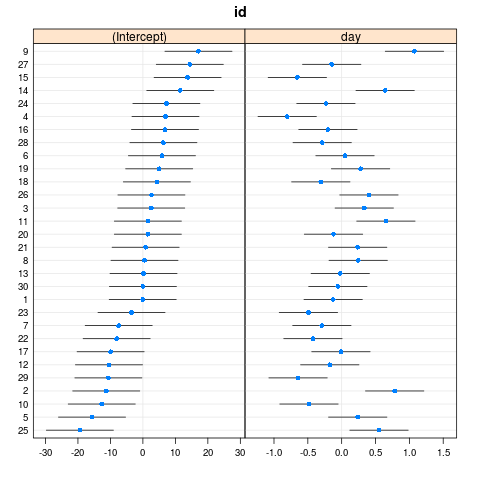

In [5]:
"""
re1 <- ranef(m1, condVar = TRUE)
print(dotplot(re1, scales = list(x = list(relation = 'free'))))[[1]]
""" |> reval;

We can check for non-negligible correlation of the random effects by fitting a model with uncorrelated random effects and comparing the fits.

In [6]:
"""
m2 <- lmer(weight ~ 1 + day + (1|id) + (0 + day|id), rats, REML = FALSE)
options(show.signif.stars = FALSE)
anova(m2, m1)
""" |> reval

RCall.RObject{RCall.VecSxp}
$id

Data: rats
Models:
m2: weight ~ 1 + day + (1 | id) + (0 + day | id)
m1: weight ~ 1 + day + (1 + day | id)
   Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
m2  5 1106.4 1121.5 -548.21   1096.4                         
m1  6 1108.1 1126.1 -548.03   1096.1 0.3645      1      0.546


In [7]:
rcall(:summary, :m2)

RCall.RObject{RCall.VecSxp}
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: weight ~ 1 + day + (1 | id) + (0 + day | id)
   Data: rats

     AIC      BIC   logLik deviance df.resid 
  1106.4   1121.5   -548.2   1096.4      145 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5962 -0.5331  0.1162  0.5036  2.5868 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 101.6460 10.0820 
 id.1     day           0.2319  0.4815 
 Residual              36.8273  6.0686 
Number of obs: 150, groups:  id, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept) 106.5676     2.2014   48.41
day           6.1857     0.1012   61.14

Correlation of Fixed Effects:
    (Intr)
day -0.247


## Fitting the same models with lmm in Julia

First we copy the `rats` data frame from R to Julia then fit the models

In [8]:
@rget rats
using DataFrames, Mamba, MixedModels
m1 = fit!(lmm(weight ~ 1 + day + (1 + day|id), rats))

Linear mixed model fit by maximum likelihood
 logLik: -548.028661, deviance: 1096.057323, AIC: 1108.057323, BIC: 1126.121134

Variance components:
            Variance    Std.Dev.    Corr.
 id       110.13709780 10.4946223
            0.24952373  0.4995235 -0.15
 Residual  36.17567166  6.0146215
 Number of obs: 150; levels of grouping factors: 30

  Fixed-effects parameters:
             Estimate Std.Error z value
(Intercept)   106.568   2.25909 47.1728
day           6.18571  0.103819 59.5817


The two mixed-models packages agree on the fit.  The amount of time required for the lmm fit is

In [14]:
@time fit!(lmm(weight ~ 1 + day + (1 + day|id), rats));

  0.036410 seconds (65.12 k allocations: 2.556 MB)


In [15]:
@time m2 = fit!(lmm(weight ~ 1 + day + (1|id) + (0 + day|id), rats))

Linear mixed model fit by maximum likelihood
 logLik: -548.210888, deviance: 1096.421776, AIC: 1106.421776, BIC: 1121.474952

Variance components:
           Variance    Std.Dev.  
 id       101.649399 10.08213268
 id         0.231884  0.48154336
 Residual  36.827169  6.06853932
 Number of obs: 150; levels of grouping factors: 30, 30

  Fixed-effects parameters:
             Estimate Std.Error z value
(Intercept)   106.568   2.20145  48.408
day           6.18571  0.101167 61.1437


0.001834 seconds (17.35 k allocations: 393.766 KB)


In [11]:
MixedModels.lrt(m2, m1)  # print format is still a bit primitive

,Df,Deviance,Chisq,pval
1,5,1096.4217755845466,NaN,NaN
2,6,1096.0573227152915,0.3644528692550466,0.5460435661578722


0.637553 seconds (770.74 k allocations: 34.822 MB, 2.01% gc time)


## Fitting the model with Stan

## A Mamba MCMC analysis of the independent random effects model

[Brian Smith](http://www.public-health.uiowa.edu/people/brian-smith/), the principal author of the [Mamba package](https://github.com/brian-j=smith/Mamba.jl) provides a BUGS-like approach to this model in the [Mamba documentation](http://mambajl.readthedocs.org/en/latest/examples/rats.html) which we will adapt here.  First we need to convert the data in the `ratsL` DataFrame, which are stored as `DataArray` types, to vectors.  These are stored in a dictionary with keys that are symbols.  This is similar to an R list except that there is no inherent ordering of the elements.  You can retrieve values by name (symbol) but not by index number.

In [12]:
ratsD = Dict{Symbol,Any}(
    :weight => convert(Vector{Float64}, ratsL[:weight]),
    :day => convert(Vector{Float64}, ratsL[:day]),
    :dayc => convert(Vector, ratsL[:dayc]),
    :id => convert(Vector{Int}, ratsL[:id]));
ratsD[:N] = length(unique(ratsD[:id]));
ratsD[:T] = length(unique(ratsD[:day]));
ratsD

LoadError: LoadError: UndefVarError: ratsL not defined
while loading In[12], in expression starting on line 1

In [13]:
model = Model(

y = Stochastic(1,
    function(α, β, dayc, id, σ²)
        μ = α[id] + β[id] .* daysc
        MvNormal(μ, sqrt(σ²))
    end,
    false
),

α = Stochastic(1,
    (μα, σ²α) -> Normal(μα, sqrt(σ²α)),
    false
),

α0 = Logical((μα, xbar, μβ) -> μα - xbar * μβ),

μα = Stochastic(() -> Normal(0.0, 1000), false),

σ²α = Stochastic(() -> InverseGamma(0.001, 0.001), false),

β = Stochastic(1, (μβ, σ²β) -> Normal(μβ, sqrt(σ²β)), false),

μβ = Stochastic(() -> Normal(0.0, 1000)),

σ²β= Stochastic(() -> InverseGamma(0.001, 0.001), false),

σ² = Stochastic(() -> InverseGamma(0.001, 0.001))

)



Object of type "Mamba.Model"
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
μβ:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
σ²α:
An unmonitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
μα:
An unmonitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
α0:
A monitored node of type "Mamba.ScalarLogical"
NaN
-------------------------------------------------------------------------------
α:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
σ²β:
An unmonitored